<a href="https://colab.research.google.com/github/Mayukhmaity/DeepLearning_NLP/blob/main/Language_Translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving deu.txt to deu.txt
User uploaded file "deu.txt" with length 12316220 bytes


In [9]:
#https://raw.githubusercontent.com/Apress/applied-natural-language-processing-w-python/master/data_etc/deu.txt
from google.colab import files
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [10]:
deu_eng = deu_eng[:50000,:]

In [11]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['Tom lost seventy pounds.', 'Tom hat 30\xa0kg abgenommen.'],
       ['Tom loves fried chicken.', 'Tom isst sehr gerne Brathähnchen.'],
       ['Tom loves fried chicken.', 'Tom isst sehr gerne Brathendl.']],
      dtype='<U302')

In [12]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [13]:
deu_eng

array([['hi.', 'hallo!'],
       ['hi.', 'grüß gott!'],
       ['run!', 'lauf!'],
       ...,
       ['tom lost seventy pounds.', 'tom hat 30\xa0kg abgenommen.'],
       ['tom loves fried chicken.', 'tom isst sehr gerne brathähnchen.'],
       ['tom loves fried chicken.', 'tom isst sehr gerne brathendl.']],
      dtype='<U302')

In [14]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [15]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

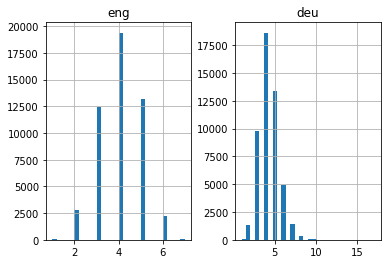

In [16]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [17]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [18]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6500


In [19]:

# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 11089


In [20]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [22]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [23]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [24]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [27]:

model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - 237s 4s/step - loss: 3.6527 - val_loss: 3.1200

Epoch 00001: val_loss improved from inf to 3.11998, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 2/30
63/63 [==============================] - 231s 4s/step - loss: 3.0071 - val_loss: 2.9688

Epoch 00002: val_loss improved from 3.11998 to 2.96879, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 3/30
63/63 [==============================] - 231s 4s/step - loss: 2.8318 - val_loss: 2.7796

Epoch 00003: val_loss improved from 2.96879 to 2.77958, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 4/30
63/63 [==============================] - 230s 4s/step - loss: 2.6469 - val_loss: 2.6477

Epoch 00004: val_loss improved from 2.77958 to 2.64775, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 5/30
63/63 [==============================] - 238s 4s/step - loss: 2.5008 - val_loss: 2.5322

Epoch 00005: val_loss improved from 2.64775 to 2.53222, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 6/30
63/63 [==============================] - 265s 4s/step - loss: 2.3669 - val_loss: 2.4460

Epoch 00006: val_loss improved from 2.53222 to 2.44597, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 7/30
63/63 [==============================] - 265s 4s/step - loss: 2.2553 - val_loss: 2.3828

Epoch 00007: val_loss improved from 2.44597 to 2.38281, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 8/30
63/63 [==============================] - 278s 4s/step - loss: 2.1503 - val_loss: 2.3285

Epoch 00008: val_loss improved from 2.38281 to 2.32847, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 9/30
63/63 [==============================] - 271s 4s/step - loss: 2.0527 - val_loss: 2.2386

Epoch 00009: val_loss improved from 2.32847 to 2.23857, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 10/30
63/63 [==============================] - 275s 4s/step - loss: 1.9518 - val_loss: 2.1710

Epoch 00010: val_loss improved from 2.23857 to 2.17099, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 11/30
21/63 [=========>....................] - ETA: 2:54 - loss: 1.8590

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()